In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.rcParams['figure.autolayout'] = True

SAVE_PLOTS = True
STANDARD_DPI = 300
DOTSIZE = 5
FIGSIZE = (5, 3)

In [94]:
def load_h5_data(file_path):
    data = {}
    with h5py.File(file_path, 'r') as f:
        for voltage in f.keys():
            data[int(voltage)] = {'CH1': [], 'CH2': []}

            for i in f[voltage]['CH1']:
                arr = np.array(f[voltage]['CH1'][i])  # Load as NumPy array
                # Convert to DataFrame
                df = pd.DataFrame(arr, columns=['t', 'V'])
                data[int(voltage)]['CH1'].append(df)

            for i in f[voltage]['CH2']:
                arr = np.array(f[voltage]['CH2'][i])
                df = pd.DataFrame(arr, columns=['t', 'V'])
                data[int(voltage)]['CH2'].append(df)
    return data


def load_h5_data_from_params(pmt_number, is_attenuated):
    data_path = f'data/gain_fixed_light/pmt{pmt_number}/signals'
    data_path += '_50ohm.h5' if is_attenuated else '.h5'
    return load_h5_data(data_path)


def get_noise_data(pmt_number, is_attenuated):
    data_path = f'data/dark_pmt/pmt{pmt_number}/I_V_noise_700_2285V'
    data_path += '_50ohm.csv' if is_attenuated else '.csv'
    noise_data = pd.read_csv(data_path)
    noise_data['V_set'] = noise_data['pmt_high_voltage'].round(0)
    return noise_data


def generate_save_path(pmt_number, is_attenuated, filename):
    plot_path = f'plots/pmt_noise_tests/pmt{pmt_number}/{filename}'
    plot_path += '_50ohm' if is_attenuated else ''
    plot_path += '.jpg'
    return plot_path


def get_average_p2p(signals, channel_key):
    avg_p2ps = []
    for s in signals.values():

        p2ps = [d['V'].max() - d['V'].min() for d in s[channel_key]]
        avg_p2ps.append(np.mean(p2ps))
    return avg_p2ps


def generate_sigtonoise_df(signals, noise_data):
    df = {
        'V': list(signals.keys()),
        'p2p_ch1': get_average_p2p(signals, 'CH1'),
        'p2p_ch2': get_average_p2p(signals, 'CH2')
    }
    df = pd.DataFrame(df)
    df['noise_ch1_p2p'] = df['V'].apply(
        lambda v: noise_data[noise_data['V_set'] == v]['v_p2p_ch1'].values[0])
    df['noise_ch2_p2p'] = df['V'].apply(
        lambda v: noise_data[noise_data['V_set'] == v]['v_p2p_ch2'].values[0])

    df['noise_ch1_rms'] = df['V'].apply(
        lambda v: noise_data[noise_data['V_set'] == v]['v_rms_ch1'].values[0])
    df['noise_ch2_rms'] = df['V'].apply(
        lambda v: noise_data[noise_data['V_set'] == v]['v_rms_ch2'].values[0])
    df['sig2noisep2p_ch1'] = df['p2p_ch1'] / df['noise_ch1_p2p']
    df['sig2noisep2p_ch2'] = df['p2p_ch2'] / df['noise_ch2_p2p']
    df['sig2noiserms_ch1'] = df['p2p_ch1'] / df['noise_ch1_rms']
    df['sig2noiserms_ch2'] = df['p2p_ch2'] / df['noise_ch2_rms']
    return df


def generate_plot_title(quantity_name, pmt_number, is_terminated: bool):
    plot_title = quantity_name
    plot_title += ' - '
    plot_title += f'PMT {pmt_number}'
    plot_title += ' , '
    plot_title += r' 50$\Omega$ term.' if is_terminated else r' 1$M\Omega$ term.'
    return plot_title

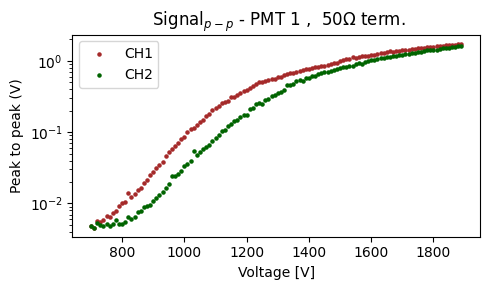

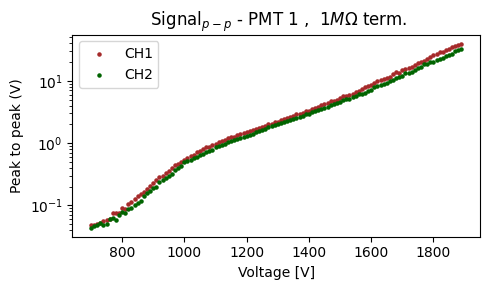

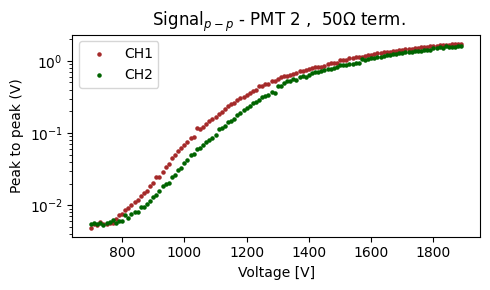

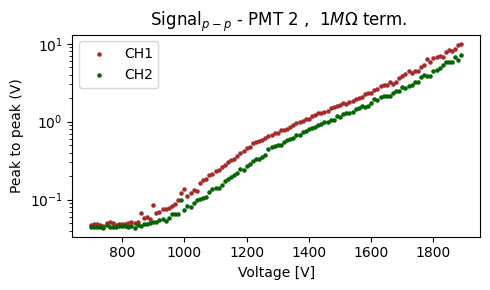

In [95]:
def plot_sigp2p(pmt_number, is_terminated):
    noise_data = get_noise_data(pmt_number, is_terminated)
    signals = load_h5_data_from_params(pmt_number, is_terminated)
    df = generate_sigtonoise_df(signals, noise_data)

    fig, ax = plt.subplots(figsize=FIGSIZE)

    ax.scatter(df['V'], df['p2p_ch1'], label='CH1', color='brown', s=DOTSIZE)
    ax.scatter(df['V'], df['p2p_ch2'], label='CH2',
               color='darkgreen', s=DOTSIZE)
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Peak to peak (V)')

    ax.set_yscale('log')

    quantity_name = r' Signal$_{p-p}$'
    plot_title = generate_plot_title(quantity_name, pmt_number, is_terminated)
    ax.set_title(plot_title)
    ax.legend()

    if SAVE_PLOTS:
        plot_path = generate_save_path(pmt_number, is_terminated, 'sigp2p')
        plt.savefig(plot_path, dpi=STANDARD_DPI)

    plt.show()


for pmt_number in range(1, 3):
    for is_terminated in [True, False]:
        plot_sigp2p(pmt_number, is_terminated)

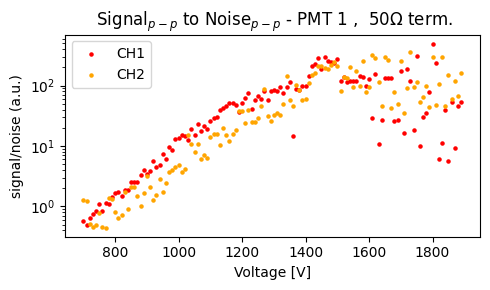

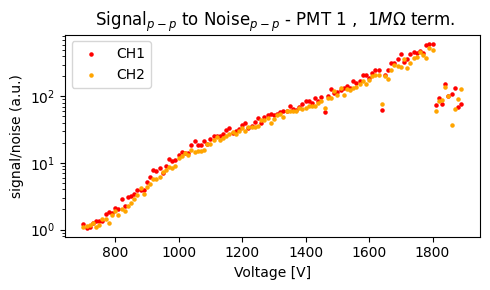

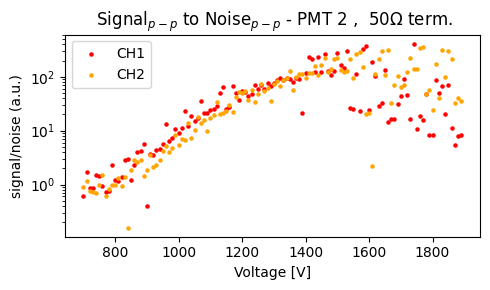

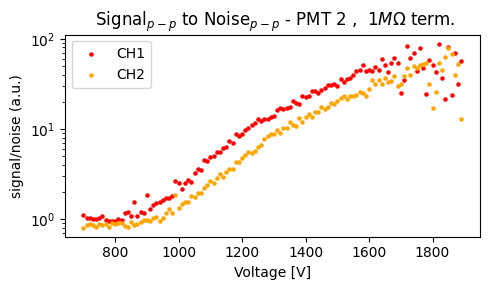

In [96]:
def plot_sigp2p_vs_noise_p2p(pmt_number, is_terminated):
    noise_data = get_noise_data(pmt_number, is_terminated)
    signals = load_h5_data_from_params(pmt_number, is_terminated)
    df = generate_sigtonoise_df(signals, noise_data)

    fig, ax = plt.subplots(figsize=FIGSIZE)

    ax.scatter(df['V'], df['sig2noisep2p_ch1'],
               label='CH1', color='red', s=DOTSIZE)
    ax.scatter(df['V'], df['sig2noisep2p_ch2'],
               label='CH2', color='orange', s=DOTSIZE)
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('signal/noise (a.u.)')

    ax.set_yscale('log')

    quantity_name = r' Signal$_{p-p}$ to Noise$_{p-p}$'
    plot_title = generate_plot_title(quantity_name, pmt_number, is_terminated)
    ax.set_title(plot_title)
    ax.legend()

    if SAVE_PLOTS:
        plot_path = generate_save_path(
            pmt_number, is_terminated, 'sigp2p_to_noisep2p')
        plt.savefig(plot_path, dpi=STANDARD_DPI)


for pmt_number in range(1, 3):
    for is_terminated in [True, False]:
        plot_sigp2p_vs_noise_p2p(pmt_number, is_terminated)

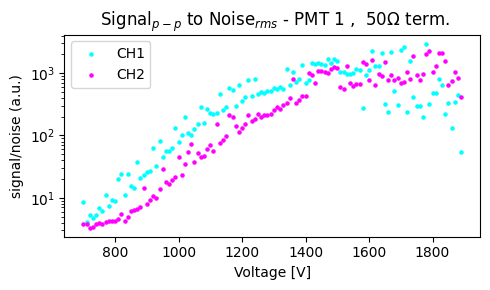

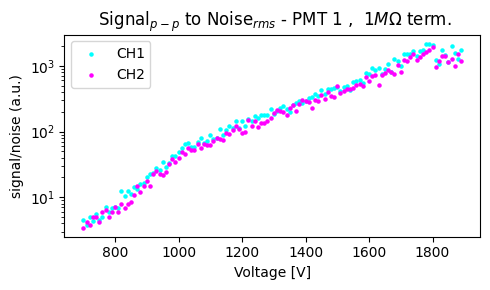

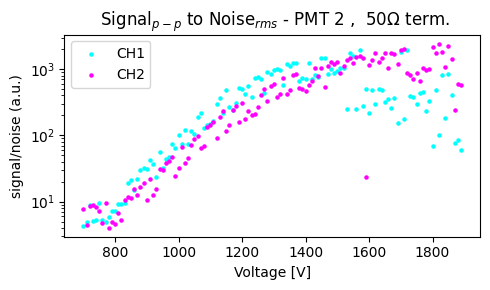

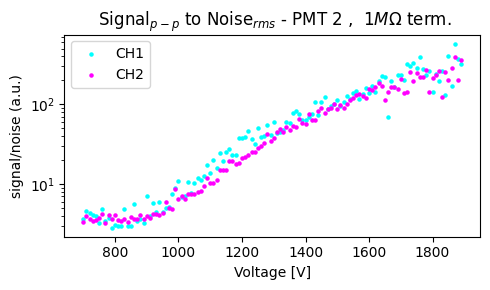

In [97]:
def plot_sigp2p_vs_noiserms(pmt_number, is_terminated):
    noise_data = get_noise_data(pmt_number, is_terminated)
    signals = load_h5_data_from_params(pmt_number, is_terminated)
    df = generate_sigtonoise_df(signals, noise_data)

    fig, ax = plt.subplots(figsize=(5, 3))

    ax.scatter(df['V'], df['sig2noiserms_ch1'],
               label='CH1', color='cyan', s=DOTSIZE)
    ax.scatter(df['V'], df['sig2noiserms_ch2'],
               label='CH2', color='magenta', s=DOTSIZE)
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('signal/noise (a.u.)')

    ax.set_yscale('log')

    quantity_name = r' Signal$_{p-p}$ to Noise$_{rms}$'
    plot_title = generate_plot_title(quantity_name, pmt_number, is_terminated)
    ax.set_title(plot_title)
    ax.legend()

    if SAVE_PLOTS:
        plot_path = generate_save_path(
            pmt_number, is_terminated, 'sigp2p_to_noiserms')
        plt.savefig(plot_path, dpi=STANDARD_DPI)


for pmt_number in range(1, 3):
    for is_terminated in [True, False]:
        plot_sigp2p_vs_noiserms(pmt_number, is_terminated)